# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [1]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!pip install matplotlib

In [4]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/ff1010bird-duration7/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/ff1010bird-duration7/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/ff1010bird-duration7/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [5]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

     |████████████████████████████████| 431 kB 763 kB/s            


In [6]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [7]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [8]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [9]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [11]:
def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [12]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth


Epoch: [1][1/192] Data 0.983 (0.983) Elapsed 0m 7s (remain 24m 54s) Loss: 0.6861(0.6861) Grad: 44.5738  
Epoch: [1][101/192] Data 0.000 (0.010) Elapsed 0m 38s (remain 0m 35s) Loss: 0.3485(0.5323) Grad: 17.9507  
Epoch: [1][192/192] Data 0.000 (0.006) Elapsed 1m 6s (remain 0m 0s) Loss: 0.5620(0.4709) Grad: 29.5258  
EVAL: [1/49] Data 0.512 (0.512) Elapsed 0m 0s (remain 0m 28s) Loss: 0.3582(0.3582) 


Epoch 1 - avg_train_loss: 0.4709  avg_val_loss: 0.3804  time: 73s
Epoch 1 - Accuracy: 0.8556566970091027
Epoch 1 - Save Best Score: 0.8557 Model


EVAL: [49/49] Data 0.000 (0.043) Elapsed 0m 5s (remain 0m 0s) Loss: 0.3406(0.3804) 
Epoch: [2][1/192] Data 0.866 (0.866) Elapsed 0m 1s (remain 3m 49s) Loss: 0.3337(0.3337) Grad: 16.2094  
Epoch: [2][101/192] Data 0.002 (0.009) Elapsed 0m 32s (remain 0m 28s) Loss: 0.2844(0.3516) Grad: 15.1736  
Epoch: [2][192/192] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 0s) Loss: 0.4658(0.3365) Grad: 19.8805  
EVAL: [1/49] Data 0.337 (0.337) Elapsed 0m 0s (remain 0m 19s) Loss: 0.3556(0.3556) 


Epoch 2 - avg_train_loss: 0.3365  avg_val_loss: 0.3582  time: 64s
Epoch 2 - Accuracy: 0.8693107932379714
Epoch 2 - Save Best Score: 0.8693 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3962(0.3582) 
Epoch: [3][1/192] Data 0.827 (0.827) Elapsed 0m 1s (remain 3m 47s) Loss: 0.2753(0.2753) Grad: 11.7961  
Epoch: [3][101/192] Data 0.000 (0.009) Elapsed 0m 31s (remain 0m 28s) Loss: 0.2417(0.3088) Grad: 15.9372  
Epoch: [3][192/192] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 0s) Loss: 0.3662(0.2942) Grad: 15.6829  
EVAL: [1/49] Data 0.348 (0.348) Elapsed 0m 0s (remain 0m 20s) Loss: 0.4542(0.4542) 


Epoch 3 - avg_train_loss: 0.2942  avg_val_loss: 0.3339  time: 64s
Epoch 3 - Accuracy: 0.8797139141742523
Epoch 3 - Save Best Score: 0.8797 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4881(0.3339) 
Epoch: [4][1/192] Data 0.997 (0.997) Elapsed 0m 1s (remain 4m 27s) Loss: 0.1697(0.1697) Grad: 10.6706  
Epoch: [4][101/192] Data 0.000 (0.011) Elapsed 0m 32s (remain 0m 29s) Loss: 0.1707(0.2812) Grad: 9.2352  
Epoch: [4][192/192] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 0s) Loss: 0.2922(0.2683) Grad: 15.6587  
EVAL: [1/49] Data 0.310 (0.310) Elapsed 0m 0s (remain 0m 18s) Loss: 0.4465(0.4465) 


Epoch 4 - avg_train_loss: 0.2683  avg_val_loss: 0.3311  time: 65s
Epoch 4 - Accuracy: 0.881664499349805
Epoch 4 - Save Best Score: 0.8817 Model


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5454(0.3311) 
Epoch: [5][1/192] Data 0.966 (0.966) Elapsed 0m 1s (remain 4m 12s) Loss: 0.1728(0.1728) Grad: 11.1087  
Epoch: [5][101/192] Data 0.001 (0.010) Elapsed 0m 32s (remain 0m 29s) Loss: 0.1925(0.2457) Grad: 13.3564  
Epoch: [5][192/192] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 0s) Loss: 0.2789(0.2328) Grad: 16.7715  
EVAL: [1/49] Data 0.389 (0.389) Elapsed 0m 0s (remain 0m 22s) Loss: 0.4162(0.4162) 


Epoch 5 - avg_train_loss: 0.2328  avg_val_loss: 0.3323  time: 65s
Epoch 5 - Accuracy: 0.8823146944083224
Epoch 5 - Save Best Score: 0.8823 Model


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4877(0.3323) 
Epoch: [6][1/192] Data 0.896 (0.896) Elapsed 0m 1s (remain 3m 57s) Loss: 0.2418(0.2418) Grad: 11.7232  
Epoch: [6][101/192] Data 0.000 (0.010) Elapsed 0m 32s (remain 0m 28s) Loss: 0.1245(0.2152) Grad: 8.9393  
Epoch: [6][192/192] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 0s) Loss: 0.2430(0.2015) Grad: 13.7379  
EVAL: [1/49] Data 0.313 (0.313) Elapsed 0m 0s (remain 0m 19s) Loss: 0.4529(0.4529) 


Epoch 6 - avg_train_loss: 0.2015  avg_val_loss: 0.3578  time: 64s
Epoch 6 - Accuracy: 0.8849154746423927
Epoch 6 - Save Best Score: 0.8849 Model


EVAL: [49/49] Data 0.000 (0.007) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6891(0.3578) 
Epoch: [7][1/192] Data 0.837 (0.837) Elapsed 0m 1s (remain 3m 43s) Loss: 0.1378(0.1378) Grad: 14.1288  
Epoch: [7][101/192] Data 0.000 (0.009) Elapsed 0m 32s (remain 0m 29s) Loss: 0.0856(0.1924) Grad: 8.5511  
Epoch: [7][192/192] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 0s) Loss: 0.2248(0.1757) Grad: 14.3300  
EVAL: [1/49] Data 0.339 (0.339) Elapsed 0m 0s (remain 0m 20s) Loss: 0.4822(0.4822) 


Epoch 7 - avg_train_loss: 0.1757  avg_val_loss: 0.3496  time: 64s
Epoch 7 - Accuracy: 0.88296488946684


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6277(0.3496) 
Epoch: [8][1/192] Data 0.894 (0.894) Elapsed 0m 1s (remain 3m 54s) Loss: 0.1445(0.1445) Grad: 12.2100  
Epoch: [8][101/192] Data 0.000 (0.009) Elapsed 0m 31s (remain 0m 28s) Loss: 0.1504(0.1690) Grad: 11.8613  
Epoch: [8][192/192] Data 0.000 (0.005) Elapsed 0m 59s (remain 0m 0s) Loss: 0.2302(0.1527) Grad: 14.9345  
EVAL: [1/49] Data 0.370 (0.370) Elapsed 0m 0s (remain 0m 21s) Loss: 0.5256(0.5256) 


Epoch 8 - avg_train_loss: 0.1527  avg_val_loss: 0.3492  time: 64s
Epoch 8 - Accuracy: 0.8894668400520156
Epoch 8 - Save Best Score: 0.8895 Model


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6197(0.3492) 
Epoch: [9][1/192] Data 0.647 (0.647) Elapsed 0m 0s (remain 3m 9s) Loss: 0.1414(0.1414) Grad: 20.5579  
Epoch: [9][101/192] Data 0.001 (0.007) Elapsed 0m 32s (remain 0m 28s) Loss: 0.1206(0.1514) Grad: 12.5111  
Epoch: [9][192/192] Data 0.000 (0.004) Elapsed 0m 59s (remain 0m 0s) Loss: 0.1412(0.1360) Grad: 14.3256  
EVAL: [1/49] Data 0.361 (0.361) Elapsed 0m 0s (remain 0m 21s) Loss: 0.5584(0.5584) 


Epoch 9 - avg_train_loss: 0.1360  avg_val_loss: 0.3487  time: 64s
Epoch 9 - Accuracy: 0.8875162548764629


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5071(0.3487) 
Epoch: [10][1/192] Data 0.932 (0.932) Elapsed 0m 1s (remain 4m 11s) Loss: 0.1060(0.1060) Grad: 7.7375  
Epoch: [10][101/192] Data 0.001 (0.010) Elapsed 0m 32s (remain 0m 28s) Loss: 0.0695(0.1501) Grad: 8.8940  
Epoch: [10][192/192] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 0s) Loss: 0.2336(0.1335) Grad: 16.8564  
EVAL: [1/49] Data 0.377 (0.377) Elapsed 0m 0s (remain 0m 21s) Loss: 0.5625(0.5625) 


Epoch 10 - avg_train_loss: 0.1335  avg_val_loss: 0.3506  time: 64s
Epoch 10 - Accuracy: 0.8855656697009102
========== CV ==========
Score: 0.88947


EVAL: [49/49] Data 0.000 (0.008) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4102(0.3506) 
TN 1120
FP 31
FN 139
TP 248


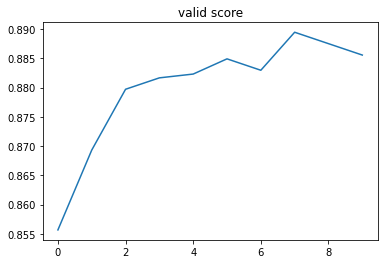

In [13]:
if __name__ == '__main__':
    main(0)